In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import requests
import urllib
# !conda install -c conda-forge folium=0.11.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import seaborn as sns
from folium.plugins import HeatMap
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

%pylab inline
plt.style.use('fivethirtyeight')
print('Libraries imported.')

Populating the interactive namespace from numpy and matplotlib
Libraries imported.


In [187]:
!wget -q -O 'data/newyork_data.json' https://cocl.us/new_york_dataset 
print('Data downloaded!')

Data downloaded!


In [2]:
with open('data/newyork_polygon.json') as json_data:
    newyork_data = json.load(json_data)
    

In [3]:
ny_df = pd.DataFrame(columns=['Neighborhood','Borough','Longitude','Latitude'])
GLOB_MIN = np.array([100000.0,10000])
GLOB_MAX = np.array([-100000.0,-10000])
for ng in newyork_data['features']:
    
    max_ = np.max(np.array(ng['geometry']['coordinates'][0]), axis = 0)
    min_ = np.min(np.array(ng['geometry']['coordinates'][0]), axis = 0)
    GLOB_MIN[0] = min(GLOB_MIN[0],min_[0])
    GLOB_MIN[1] = min(GLOB_MIN[1],min_[1])
    GLOB_MAX[0] = max(GLOB_MAX[0],max_[0])
    GLOB_MAX[1] = max(GLOB_MAX[1],max_[1])
    
    coords = min_ + (max_ - min_)/2
    ny_df.loc[-1] = [ng['properties']['neighborhood'],ng['properties']['borough']] + coords.tolist() 
        
    ny_df = ny_df.reset_index(drop=True)

ny_df['Borough']  = ny_df.Borough.astype('category')

ny_df['Borough_code'] = ny_df.Borough.cat.codes

ny_df = ny_df.groupby(['Neighborhood']).mean().reset_index()

In [4]:
#Convert long lat to xy-coordinates (linearized)
lat_conv = 0.69
long_conv = 0.52
ny_df['Latitude'] *= lat_conv
ny_df['Longitude'] *= long_conv

### Get rent data (one bdroom, source: https://streeteasy.com/blog/data-dashboard/)

In [5]:
rent_df = pd.read_csv('data/medianAskingRent_OneBd.csv', index_col = 0 )
rent_df = rent_df[['All' not in i for i in rent_df.index]]
rent_df['mean_2019'] = rent_df.filter(like='2019',axis=1).mean(axis=1).to_frame()

In [6]:
ny_df_rent = pd.merge(ny_df, rent_df[['mean_2019']], how='left',left_on='Neighborhood',right_index=True)

In [9]:
world_map = folium.Map(location=[40.7896239, -73.9598939], zoom_start=11,width='100%',height='100%')



choropleth = folium.Choropleth(geo_data='data/newyork_polygon.json', 
                    data=ny_df_rent, columns=['Neighborhood','mean_2019'],key_on='feature.properties.neighborhood',
                    fill_color='YlOrRd', 
                    fill_opacity=0.7, 
                    line_opacity=1,
                    line_color='black',
                    legend_name='').add_to(world_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['neighborhood'], labels=False)
)
world_map

In [10]:
world_map.save('fig/rent_test.html')

### Model to predict rent from sale prices (source: https://streeteasy.com/blog/data-dashboard/)

In [194]:
sale_df = pd.read_csv('data/medianSalesPrice_All.csv', index_col = 0 )

sale_df = sale_df[['All' not in i for i in sale_df.index]]

sale_df['mean_2019'] = sale_df.filter(like='2019',axis=1).mean(axis=1).to_frame()

In [195]:
asking_df = pd.read_csv('data/medianAskingPrice_All.csv', index_col = 0 )

asking_df = asking_df[['All' not in i for i in asking_df.index]]

asking_df['mean_2019'] = asking_df.filter(like='2019',axis=1).mean(axis=1).to_frame()

Where sale price is not available, impute with asking price

In [196]:
sale_df['mean_2019_imp'] = sale_df['mean_2019'].fillna(asking_df.mean_2019)

In [197]:
real_estate_df = pd.merge(sale_df[['mean_2019_imp']],rent_df, how='inner',left_index=True,right_index=True).rename({'mean_2019_imp':'mean_2019_sale'},axis=1)

real_estate_df = real_estate_df[['mean_2019_sale','mean_2019','Borough']].dropna()

real_estate_df = pd.concat([real_estate_df, pd.get_dummies(real_estate_df['Borough'])],axis=1).drop('Borough', axis=1)

In [198]:
X = real_estate_df.drop('mean_2019', axis = 1)
y = real_estate_df['mean_2019']

In [199]:
all_idx = X.index
train_idx, test_idx = train_test_split(all_idx, test_size=0.2, shuffle=True,random_state=42)
train_idx = X.index
test_idx = []

In [200]:
from sklearn.kernel_ridge import KernelRidge as KRR

In [201]:
cv_sales = GridSearchCV(Pipeline([('poly',PolynomialFeatures(1)),
                       ('lr',Ridge())]),
                         param_grid={'poly__degree':[1, 2],'lr__alpha':[1,0.1,0.01]},cv=8)
cv_sales.fit(X.loc[train_idx],y.loc[train_idx]);



/home/sebastian/miniconda3/envs/dscience/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.46193e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/sebastian/miniconda3/envs/dscience/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.60322e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/sebastian/miniconda3/envs/dscience/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.5085e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/sebastian/miniconda3/envs/dscience/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.53444e-27): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/sebastian/miniconda3/envs/dscience/lib/python3.8/site-p

In [240]:
cv_sales.best_params_

{'lr__alpha': 1, 'poly__degree': 2}

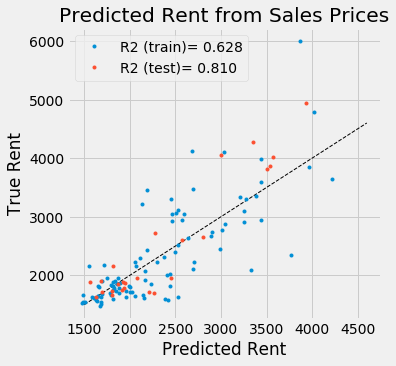

In [154]:
figsize(5,5)
plot([1500,4600],[1500,4600],ls='--',marker='',lw=1, color='black')

plot(cv_sales.predict(X.loc[train_idx]), y.loc[train_idx], ls ='', marker='.', label = "R2 (train)= {:.3f}".format(cv_sales.score(X.loc[train_idx], y.loc[train_idx])))
plot(cv_sales.predict(X.loc[test_idx]), y.loc[test_idx], ls ='', marker='.', label = "R2 (test)= {:.3f}".format(cv_sales.score(X.loc[test_idx], y.loc[test_idx])))
# print("R2= {:.3f}".format(cv_sales.score(X.loc[test_idx], y.loc[test_idx])))
xlabel('Predicted Rent')
ylabel('True Rent')
legend();
title('Predicted Rent from Sales Prices')
savefig('fig/rent_from_sales.pdf',bbox_inches='tight')
savefig('fig/rent_from_sales.png',bbox_inches='tight')

In [202]:
real_estate_df['predicted_from_sales'] = cv_sales.predict(X)

### Model to predict rent from neighbors 

In [203]:
ny_df_rent.head()

,Neighborhood,Longitude,Latitude,Borough_code,mean_2019
0,Allerton,-38.406380,28.197026,0,NaN
1,Alley Pond Park,-38.348666,28.118308,3,NaN
2,Arden Heights,-38.574376,27.982008,4,NaN
3,Arlington,-38.562912,28.043570,4,NaN
4,Arrochar,-38.518130,28.008768,4,NaN


In [204]:
X = ny_df_rent.set_index('Neighborhood').dropna(axis=0)[['Longitude','Latitude']]
y = ny_df_rent.set_index('Neighborhood').dropna(axis=0)['mean_2019']

In [205]:
train_idx = [i for i in X.index if i not in test_idx]
test_idx = [i for i in X.index if i  in test_idx]

In [206]:
cv = GridSearchCV(KNeighborsRegressor(),
                         param_grid={'n_neighbors':[1,2,3,4,5,6,7],'weights': ['uniform'],'p':[1,2]},cv=8)

In [207]:
cv.fit(X.loc[train_idx],y.loc[train_idx])

GridSearchCV(cv=8, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7], 'p': [1, 2],
                         'weights': ['uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [208]:
pd.DataFrame(cv.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
4,0.000951,0.000152,0.000915,0.000110,3,1,uniform,"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}",0.837562,0.796147,0.734203,0.900282,0.670006,0.814899,0.611211,0.908111,0.784053,0.098885,1
5,0.000870,0.000096,0.000895,0.000088,3,2,uniform,"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}",0.848955,0.811488,0.715147,0.916162,0.747889,0.741004,0.602767,0.879631,0.782880,0.095076,2
7,0.000828,0.000014,0.000853,0.000048,4,2,uniform,"{'n_neighbors': 4, 'p': 2, 'weights': 'uniform'}",0.867476,0.672106,0.705128,0.871306,0.690044,0.783619,0.634068,0.922850,0.768325,0.101213,3
13,0.000804,0.000003,0.000816,0.000011,7,2,uniform,"{'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}",0.882595,0.628074,0.679170,0.926576,0.603071,0.748334,0.721136,0.920586,0.763693,0.121792,4
6,0.000832,0.000018,0.000838,0.000017,4,1,uniform,"{'n_neighbors': 4, 'p': 1, 'weights': 'uniform'}",0.837393,0.687015,0.701627,0.827803,0.636618,0.812748,0.693995,0.906085,0.762910,0.088710,5


In [209]:
print(cv.best_params_)

{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}


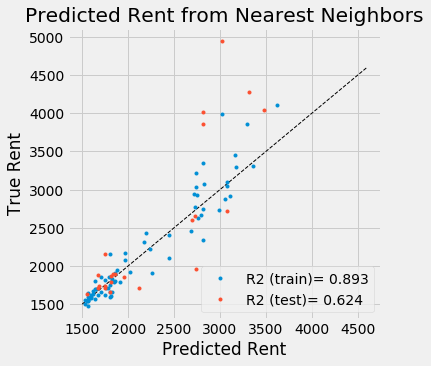

In [163]:
figsize(5,5)
plot([1500,4600],[1500,4600],ls='--',marker='',lw=1, color='black')

plot(cv.predict(X.loc[train_idx]), y.loc[train_idx], ls ='', marker='.', label = "R2 (train)= {:.3f}".format(cv.score(X.loc[train_idx], y.loc[train_idx])))
plot(cv.predict(X.loc[test_idx]), y.loc[test_idx], ls ='', marker='.', label = "R2 (test)= {:.3f}".format(cv.score(X.loc[test_idx], y.loc[test_idx])))
# print("R2= {:.3f}".format(cv_sales.score(X.loc[test_idx], y.loc[test_idx])))
xlabel('Predicted Rent')
ylabel('True Rent')
legend();
title('Predicted Rent from Nearest Neighbors')
savefig('fig/rent_from_neighbors.pdf',bbox_inches='tight')
savefig('fig/rent_from_neighbors.png',bbox_inches='tight')

In [210]:
cv.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}

In [211]:
ny_df_rent['predicted_from_neighbors'] = cv.predict(ny_df_rent[['Longitude','Latitude']])
# convergence = []
# for i in range(1):
#     knn = KNeighborsRegressor(**cv.best_params_)
#     knn.fit(ny_df_rent[['Longitude','Latitude']], ny_df_rent.mean_2019.fillna(ny_df_rent['predicted_from_neighbors']))
#     ny_df_rent['predicted_from_neighbors'] = knn.predict(ny_df_rent[['Longitude','Latitude']])
#     convergence.append(ny_df_rent.loc[ny_df_rent.mean_2019.isna(), 'predicted_from_neighbors'].values)


### Historic data

In [212]:
yearly = pd.concat([rent_df.filter(like=str(year),axis=1).mean(axis=1).to_frame().rename({0:year},axis=1) for year in range(2010,2020)],axis=1,)

In [213]:
yearly = yearly.loc[[i for i in yearly.index if not i in test_idx]]

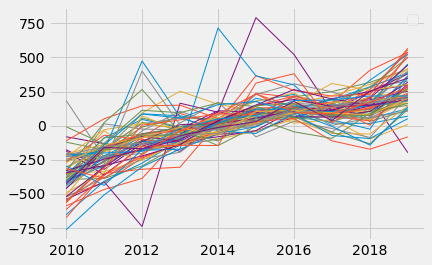

In [214]:
(yearly.dropna(axis=0).T-yearly.dropna(axis=0).T.mean()).plot(lw=1)
legend([])


In [215]:
y = (yearly.dropna(axis=0).T-yearly.dropna(axis=0).T.mean()).T.values

In [216]:
y = y.mean(axis=0)

In [217]:
X = np.array([yearly.columns]).T
X -= X.min()

In [218]:
lr_hist = LinearRegression(fit_intercept=True).fit(X,y)

array([59.69870943])

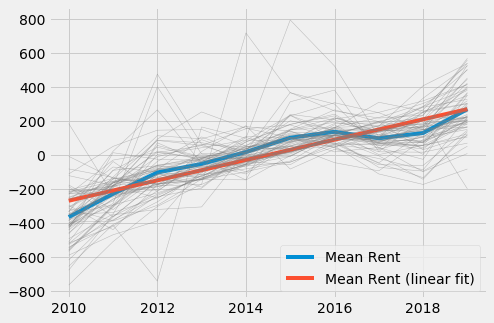

In [219]:
figsize(7,5)
fig, ax = subplots(1,1)
ax.plot(2010 + X.flatten(),y, label='Mean Rent')
ax.plot(2010 + X.flatten(),lr_hist.predict(X), label='Mean Rent (linear fit)')
legend()
(yearly.dropna(axis=0).T-yearly.dropna(axis=0).T.mean()).plot(lw=0.5, alpha=0.5,color='grey',ax=ax, legend=False)


lr_hist.coef_
# savefig('fig/rent_from_past.pdf',bbox_inches='tight')
# savefig('fig/rent_from_past.png',bbox_inches='tight')

In [220]:
yearly.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
areaName,,,,,,,,,,
Astoria,1471.666667,1743.833333,1879.916667,1818.250000,1812.5,1896.916667,1967.833333,1905.666667,1888.166667,1957.666667
Auburndale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1775.000000,NaN
Bath Beach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1441.666667,1538.777778,1614.000000
Battery Park City,2932.750000,3029.666667,3211.916667,3315.166667,3394.0,3687.416667,3655.500000,3565.750000,3714.166667,3987.500000
Bay Ridge,1314.583333,1354.250000,1385.272727,1488.833333,1525.0,1609.916667,1652.083333,1640.416667,1684.583333,1698.416667


In [221]:
ny_df_rent = ny_df_rent.set_index('Neighborhood')

In [222]:
ny_df_rent['historic_est'] = (yearly.loc[:,:'2018'] + np.arange(9,0,-1)*lr_hist.coef_).mean(axis=1).to_frame()

In [223]:
ny_df_rent['predicted_from_sales'] = real_estate_df['predicted_from_sales']

## Final model to combine the three predicted prices 

In [224]:
X = ny_df_rent.loc[~ny_df_rent['mean_2019'].isna(),['predicted_from_neighbors','historic_est','predicted_from_sales','mean_2019']]

In [225]:
hist_mask = np.random.choice([1, 0], size=len(X), p=[0.6, 0.4])
sales_mask = np.random.choice([1, 0], size=len(X), p=[0.6, 0.4])

In [226]:
X['historic_est'] *= hist_mask
X['predicted_from_sales'] *= sales_mask

In [227]:
y = X['mean_2019'].fillna(0)
X = X.drop('mean_2019', axis=1).fillna(0)

In [228]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [229]:
train_idx = [i for i in X.index if i not in test_idx] 
test_final =[i for i in X.index if i not in train_idx] 

In [230]:
cv = GridSearchCV(RandomForestRegressor(),param_grid={'n_estimators':[10,15,20],'min_samples_leaf':[1,2,3,4],'min_samples_split':[2,3,4]},cv=8)

tree = DecisionTreeRegressor()

cv.fit(X.loc[train_idx], y.loc[train_idx])

pd.DataFrame(cv.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
28,0.010692,0.000033,0.001266,0.000010,4,2,15,"{'min_samples_leaf': 4, 'min_samples_split': 2...",0.982628,0.882560,0.958621,0.970405,0.919940,0.833481,0.716256,0.876877,0.892596,0.082314,1
31,0.010663,0.000049,0.001267,0.000014,4,3,15,"{'min_samples_leaf': 4, 'min_samples_split': 3...",0.975845,0.895755,0.952379,0.968967,0.917079,0.825012,0.673005,0.924027,0.891509,0.094016,2
35,0.014099,0.000213,0.001441,0.000006,4,4,20,"{'min_samples_leaf': 4, 'min_samples_split': 4...",0.981225,0.874191,0.965376,0.971045,0.922724,0.811712,0.750447,0.839074,0.889474,0.079126,3
15,0.007560,0.000122,0.001088,0.000009,2,4,10,"{'min_samples_leaf': 2, 'min_samples_split': 4...",0.962911,0.889801,0.942765,0.957496,0.893597,0.817077,0.698094,0.942124,0.887983,0.084778,4
33,0.007408,0.000029,0.001087,0.000003,4,4,10,"{'min_samples_leaf': 4, 'min_samples_split': 4...",0.978981,0.891735,0.962159,0.966580,0.909848,0.782367,0.755245,0.854292,0.887651,0.079342,5


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

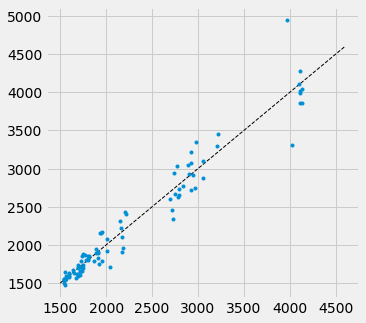

In [231]:
figsize(5,5)
plot([1500,4600],[1500,4600],ls='--',marker='',lw=1, color='black')

plot(cv.predict(X.loc[train_idx]), y.loc[train_idx], ls ='', marker='.', label = "R2 (train)= {:.3f}".format(cv.score(X.loc[train_idx], y.loc[train_idx])))
plot(cv.predict(X.loc[test_final]), y.loc[test_final], ls ='', marker='.', label = "R2 (test)= {:.3f}".format(cv.score(X.loc[test_final], y.loc[test_final])))
# print("R2= {:.3f}".format(cv_sales.score(X.loc[test_idx], y.loc[test_idx])))
xlabel('Predicted Rent')
ylabel('True Rent')
legend();
title('Predicted Rent - Ensemble model')
# savefig('fig/rent_from_ensemble.pdf',bbox_inches='tight')
# savefig('fig/rent_from_ensemble.png',bbox_inches='tight')

In [232]:
X = ny_df_rent.loc[:,['predicted_from_neighbors','historic_est','predicted_from_sales']]
# X = ny_df_rent.loc[:,['predicted_from_neighbors']]

In [233]:
ny_df_rent['predicted_rt'] = cv.predict(X.fillna(0))

In [234]:
ny_df_rent['imputed'] = ny_df_rent['mean_2019'].fillna(ny_df_rent['predicted_rt'])

In [235]:
ny_df_rent[['predicted_rt','mean_2019']].corr()

,predicted_rt,mean_2019
predicted_rt,1.000000,0.968699
mean_2019,0.968699,1.000000


In [236]:
ny_df_rent['rent_quant'] = pd.qcut(ny_df_rent.imputed,5,np.arange(5))

In [237]:
world_map = folium.Map(location=[40.7896239, -73.9598939], zoom_start=11,width='100%',height='100%')



choropleth = folium.Choropleth(geo_data='data/newyork_polygon.json', 
                    data=ny_df_rent.reset_index(), columns=['Neighborhood','imputed'],key_on='feature.properties.neighborhood',
                    fill_color='YlOrRd', 
                    fill_opacity=0.7, 
                    line_opacity=1,
                    line_color='black',
                    bins=np.arange(1300,5400,500)).add_to(world_map)

choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['neighborhood'], labels=False)
)

world_map

In [238]:
ny_df_rent.to_csv('rent.csv')

In [239]:
world_map.save('fig/rent.html')